In [54]:
import numpy as np
import pandas as pd
import os

# Necessary imports to build a LeNet model using the Keras Functional API
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Resizing

# callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# For encoding labels
from keras.utils import to_categorical

# Importing the image_dataset_from_directory utility from Keras
from keras.utils import image_dataset_from_directory

# Imports for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Imports for evaluation
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
machine = 'local'  # 'local' or 'colab'

In [5]:
#####################################
# paths:
#####################################

if machine == 'local':
    # paths to load data:
    data_dir = "..\\data\\processed\\DL\\orig_no_mask\\"  
    base_path = r"..\\data\\"
    base_path_out = os.path.join(base_path, "processed")   # path to read from the *.npy files

    # paths to save models:
    model_path = r"..\\Models\\local\\DL"

elif machine == 'colab':
    # paths to load data:
    data_dir = "/content/drive/MyDrive/data/rocessed/DL/orig_no_mask/"  
    base_path = '/content/drive/MyDrive/data'
    base_path_in = os.path.join(base_path, "processed")   # path to read from the *.npy files

    # paths to save models:
    model_path = '/content/drive/MyDrive/models/ML'

## Load data

### use image_dataset_from_directory

In [6]:
# use image_dataset_from_directory


# do I have to split into train, val and where comes the test from? 
# here is an example which splits into train and val and both are used for step model.fit, like in this example:
# model_history = model.fit(train_ds,
#                           validation_data=val_ds,
#                           epochs=50,
#                           callbacks = [reduce_learning_rate,
#                                        early_stopping,
#                                        time_callback]) 




seed_train_validation = 42 # Must be same for train_ds and val_ds
shuffle_value = True
validation_split = 0.3
batch_size = 128
image_resize = 64

train_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',                      # labels are generated from directory structure
    label_mode='categorical',               # or 'categorical'
    color_mode='grayscale',                 # images will be converted to have 1 channel
    image_size=(image_resize, image_resize),# Size to resize images to after they are read from disk
    validation_split=validation_split,      # Fraction of the data used for validation
    subset="training",                      # Load the training data
    seed=seed_train_validation,             # Seed for data splitting
    batch_size=batch_size,                  # Batch size
    shuffle = shuffle_value
)

val_ds = image_dataset_from_directory(
    data_dir,
    labels='inferred',                      # labels are generated from directory structure
    label_mode='categorical',               # or 'categorical'
    color_mode='grayscale',                 # images will be converted to have 1 channel
    image_size=(image_resize, image_resize),# Size to resize images to after they are read from disk
    validation_split=validation_split,      # Fraction of the data used for validation
    subset="validation",                    # Load the training data
    seed=seed_train_validation,             # Seed for data splitting
    batch_size=batch_size,                  # Batch size
    shuffle = shuffle_value
)






Found 21165 files belonging to 4 classes.
Using 14816 files for training.
Found 21165 files belonging to 4 classes.
Using 6349 files for validation.


## create model-name

In [7]:
model_name = 'lenet_' + 'IMGsize_' + str(image_resize )

## function

In [57]:
def create_cm(y_test, y_pred, flag_norm, model_path, model_name):
    # create and save confusion matrix

    if not (flag_norm is None):
        print("norma")
        print(flag_norm)
        cm_file     = os.path.join(model_path, "results", model_name + "_cm_norm.png")
        format_anot = '.2f'
    else:
        print("abs")
        print(flag_norm)
        cm_file     = os.path.join(model_path, "results", model_name + "_cm_abs.png")
        format_anot = 'd'

    cm = confusion_matrix(y_test, y_pred, normalize=flag_norm)

    #list_labels_enc = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

    plt.figure(figsize=(7,7))
    sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=format_anot, xticklabels=list_label_names, yticklabels=list_label_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    
    plt.savefig(cm_file, format='png')
    plt.show()

## split train, test, validation

In [8]:
# Number of batches in the training dataset
print("Number of batch in train_ds:", train_ds.cardinality().numpy())

# Number of batches in the validation dataset
print("Number of batch in val_ds:", val_ds.cardinality().numpy())

Number of batch in train_ds: 116
Number of batch in val_ds: 50


In [9]:
val_batches = val_ds.cardinality().numpy()
#val_batches
#temp = (2*val_batches) // 3
#temp
test_ds = val_ds.take((2*val_batches) // 3)  # Take elements from a tensor along an axis
val_ds = val_ds.skip((2*val_batches) // 3) 

In [10]:
# Number of batches in the training dataset
print("Number of batch in train_ds:", train_ds.cardinality().numpy())

# Number of batches in the validation dataset
print("Number of batch in val_ds:", val_ds.cardinality().numpy())

# Number of batches in the test dataset
print("Number of batch in test_ds:", test_ds.cardinality().numpy())

Number of batch in train_ds: 116
Number of batch in val_ds: 17
Number of batch in test_ds: 33


## Display some images

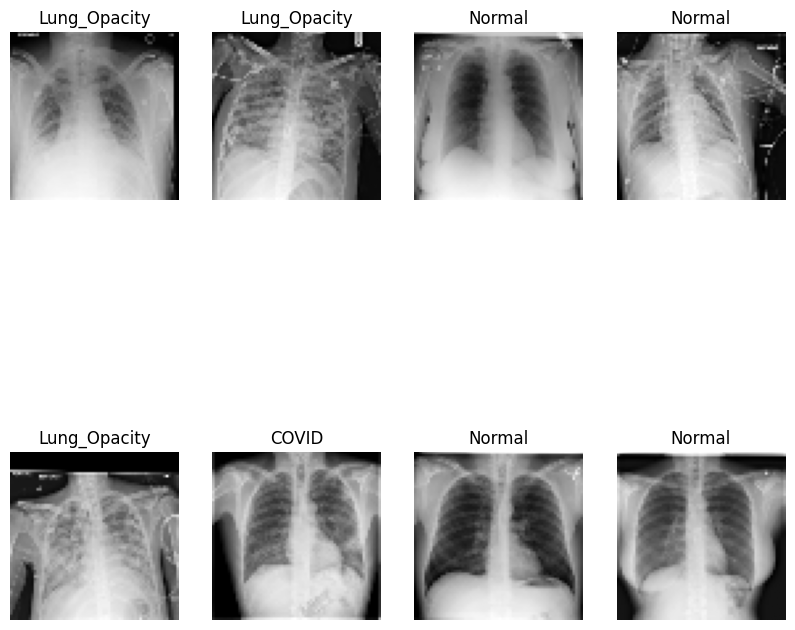

In [11]:
# Define the number of images to display
number_of_images = 8

# create a dict with the names of the label classes: 
list_label_names = train_ds.class_names                                       # get names of classes from tf object
#print(list_label_names)
dict_labels = {index: value for index, value in enumerate(list_label_names)}  # create a dict
#print(dict_labels)

# Create a figure for displaying
plt.figure(figsize=(10,10))

# Get a batch of images from train_ds
for images, labels in train_ds.take(1):

    # get labels as vector:
    labels_cat = labels.numpy().argmax(axis=1)

    # Display the images from the batch
    for i in range(number_of_images):
        ax = plt.subplot(2, 4, i + 1) 
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')  # Convert the image to integer for display
        plt.axis("off") 
        plt.title(dict_labels[labels_cat[i]])  # Display the label of the image)

# Show the images
plt.show()

## Model construction

In [12]:
# lambda layer to convert all images into grayscale

# from tensorflow.keras.layers import Lambda, Input

# # Define grayscale conversion Lambda layer
# def rgb_to_gray(x):
#     return tf.image.rgb_to_grayscale(x)

# # Example CNN input layer with grayscale conversion
# input_layer = Input(shape=(224, 224, 3))  # RGB input
# gray_layer = Lambda(rgb_to_gray)(input_layer)

### layers

In [20]:
# a) input layer: 
inputs = Input(shape=(image_resize, image_resize, 1), name="Input")

# resize image ?
# do we need it? To which size?
#resizing_layer = Resizing(50, 50)(inputs)    # Resize the images 

# b) nomalization layer: 
normalization_layer = Rescaling(1./255)

# c) LeNet model using convolutional layers and dense layers: 

# First convolutional layer
conv_1 = Conv2D(
    filters=30,                    # Number of filters
    kernel_size=(5, 5),            # Kernel dimensions
    padding='valid',               # Padding mode
    activation='relu',             # Activation function
)

# First pooling layer
max_pool_1 = MaxPooling2D(pool_size=(2, 2),)

# Second convolutional layer
conv_2 = Conv2D(
    filters=16,                    # Number of filters
    kernel_size=(3, 3),            # Kernel dimensions
    padding='valid',               # Padding mode
    activation='relu',             # Activation function
)

# Second pooling layer
max_pool_2 = MaxPooling2D(pool_size=(2, 2),)

# Dropout layer
dropout = Dropout(0.2)

# Flatten layer
flatten = Flatten()

# Dense layer 1
dense_1 = Dense(
    units=128,
    activation='relu',
)
# Dense layer as output layer
dense_2 = Dense(
    units=4,
    activation='softmax',
)

In [21]:
# Apply the layers one by one. The output of one layer becomes the input to the next.

# Feature extraction
x = normalization_layer(inputs)
x = conv_1(x)
x = max_pool_1(x)
x = conv_2(x)
x = max_pool_2(x)
x = dropout(x)

# flatten
x = flatten(x)

# # Dense layers for prediction
x = dense_1(x)
outputs = dense_2(x)

lenet = Model(inputs=inputs, outputs=outputs)

### callbacks

In [22]:
from tensorflow.keras.callbacks import Callback
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callback for early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.01,   # If the loss function doesn't change by 1% after 5 epochs, either up or down, we stop
    patience = 5,       # Wait for 5 epochs before applying
    verbose = 1,        # to display the epoch at which training stops
    mode = 'min'
)

# Callback to reduce the learning rate
reduce_learning_rate = ReduceLROnPlateau(
    monitor = 'val_loss',
    min_delta = 0.01,
    patience = 3,         # If val_loss stagnates for 3 consecutive epochs based on the min_delta value
    factor = 0.1,         # Reduce the learning rate by a factor of 0.1
    cooldown = 4,         # Wait 4 epochs before retrying 
    verbose = 1
)

# Callback to save the model
save_model_path = os.path.join(model_path, model_name + '.keras')
save = ModelCheckpoint(save_model_path, 
                                save_best_only=True, 
                                monitor='val_accuracy',
                                mode='min')

time_callback = TimingCallback() 

### compile

In [24]:
lenet.compile(loss='categorical_crossentropy', 
              optimizer='adam',                
              metrics=['accuracy'])            


In [25]:
lenet.summary()


def myprint(s):
    model_summary_file = os.path.join(model_path, 'results', model_name + '_summary.txt')
    with open(model_summary_file,'a') as f:
        print(s, file=f)

lenet.summary(print_fn=myprint)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 30)     │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         4,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,168 (1.55 MB)

 Trainable params: 407,168 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

### train

In [26]:
training_history = lenet.fit(train_ds,
                             validation_data=val_ds,
                             epochs=15,
                             batch_size=128, 
                             callbacks = [reduce_learning_rate,
                                       early_stopping,
                                       time_callback, 
                                       save])


Epoch 1/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.5618 - loss: 1.0053 - val_accuracy: 0.7096 - val_loss: 0.7114 - learning_rate: 0.0010
Epoch 2/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.7257 - loss: 0.6780 - val_accuracy: 0.7261 - val_loss: 0.6654 - learning_rate: 0.0010
Epoch 3/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.7631 - loss: 0.5934 - val_accuracy: 0.7765 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 4/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.7976 - loss: 0.5263 - val_accuracy: 0.8019 - val_loss: 0.5115 - learning_rate: 0.0010
Epoch 5/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.8098 - loss: 0.5001 - val_accuracy: 0.7967 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 6/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.8235 - loss: 0.4707 - val_accuracy: 0.8113 - val_loss: 0.4955 - learning_rate: 0.0010
Epoch 7/15
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.82

## save model

In [ ]:
# best model is saved during training

## Evaluation

In [31]:
# accuracy from training 
train_acc= training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']



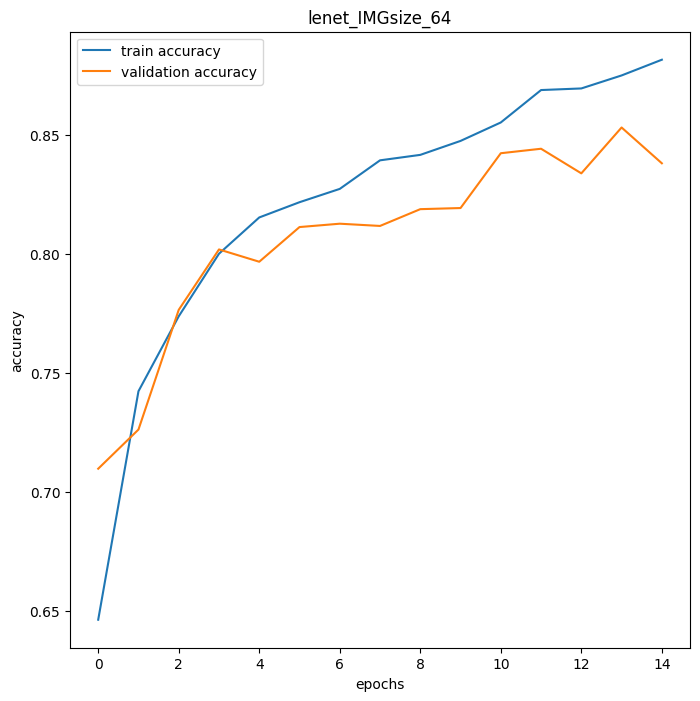

In [ ]:
# graph of training and validation accuracy

acc_plot_file = model_name + "_plot_accuracy.png"

val_acc_  = training_history.history['val_accuracy']
train_acc = training_history.history['accuracy']

# i)
plt.figure(figsize=(8,8))
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title(model_name)
plt.plot(train_acc, label="train accuracy")
plt.plot(val_acc, label="validation accuracy")

plt.legend()

# save plot
plt.savefig(os.path.join(model_path, "results", acc_plot_file), format='png')

plt.show();

In [ ]:
# load the best model:

best_model = load_model(filepath=save_model_path)

best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 30)     │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         4,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,221,506 (4.66 MB)

 Trainable params: 407,168 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 814,338 (3.11 MB)

### Classification report

In [48]:
#Create a function that uses a loop to retrieve labels batch by batch and make predictions batch by batch.

# Function to get the true labels and model predictions
def get_predictions_and_labels(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        
        preds = best_model.predict(images, verbose=0)
        pred_labels.extend(np.argmax(preds, axis=-1))

        true_labels.extend(labels.numpy().argmax(axis=-1))

    return np.array(true_labels), np.array(pred_labels)

# Get the true labels and predictions for the test set
y_true, y_pred = get_predictions_and_labels(test_ds)

# Display the classification report
print(classification_report(y_true, y_pred, target_names= list_label_names))

# save report
clf_report = classification_report(y_true, y_pred, output_dict=True, target_names= list_label_names)
df_clf_report = pd.DataFrame(clf_report).transpose()
df_clf_report.to_excel(os.path.join(model_path, "results", model_name + "_clf_report.xlsx" ), index=True)


                 precision    recall  f1-score   support

          COVID       0.73      0.17      0.28       728
   Lung_Opacity       0.58      0.83      0.68      1184
         Normal       0.77      0.80      0.79      2051
Viral Pneumonia       0.84      0.73      0.78       261

       accuracy                           0.70      4224
      macro avg       0.73      0.64      0.63      4224
   weighted avg       0.72      0.70      0.67      4224



## Confusion matrix

abs
None


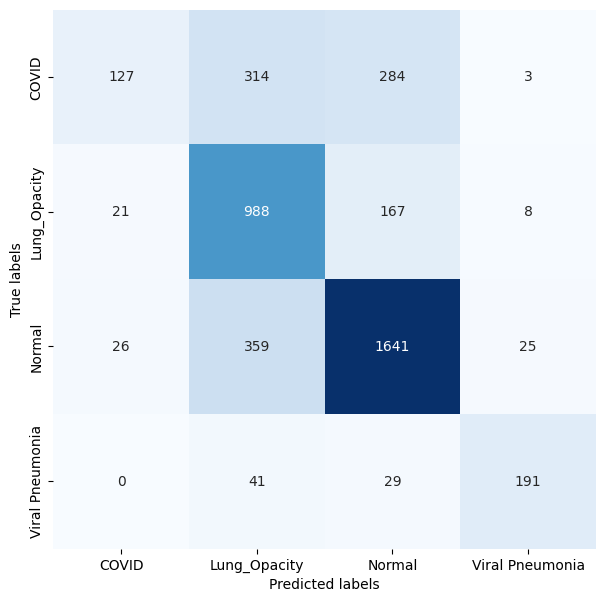

In [58]:
# show and save confusion matrix with absolute values: 
create_cm(y_true, y_pred, None , model_path, model_name)

norma
true


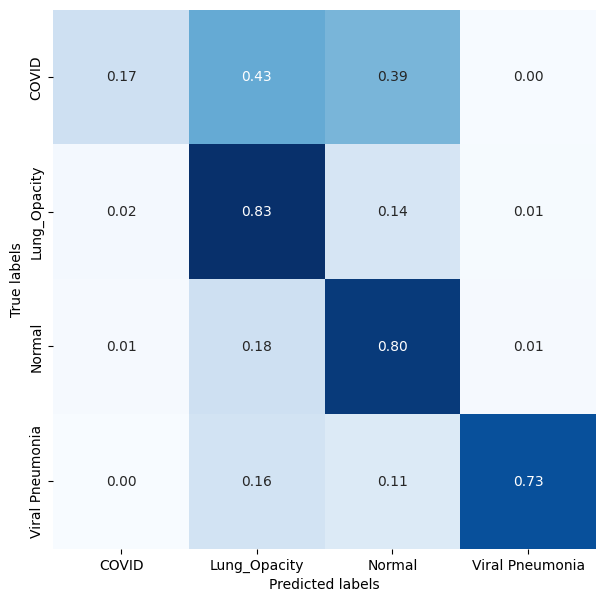

In [61]:
# show and saveonfusion matrix with normalized values: 
create_cm(y_true, y_pred, 'true' , model_path, model_name)

In [ ]:
# Calculating the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

# Plotting the confusion matrix heatmap
plt.figure(figsize=(8, 6))

plt.title("Confusion Matrix")
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt="")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Infos

In [ ]:
# when reading data: 
# - label_mode="int 
# - use when model needs integer labels
# - when using a model with: Sparse Categorical Crossentropy
# - Your model’s final activation function is Softmax, and it expects integer class labels

# - label_mode="categorical" 
# - use when model needs one-hot encoded labels
# - when using a model with: Categorical Crossentropy

